In [45]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using SpecialFunctions
using BenchmarkTools
using Test
using ForwardDiff
using LoopVectorization

In [46]:
# using Plots
# default(tickfont = font("CMU Serif", 9), 
#         titlefont = font("CMU Serif", 14), 
#         guidefont = font("CMU Serif", 12),
#         legendfont = font("CMU Serif", 10),
#         grid = false)
# pyplot()

# using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# # gr()
# using ColorSchemes

## Adding linear function to the set of features

In [72]:
Nx = 2
Ne = 20
X = randn(Nx, Ne)


B = MultiBasis(CstProHermite(8), Nx)

idx = [0 0; 0 1; 1 0; 1 1; 1 2]
truncidx = idx[1:2:end,:]

coeff =  randn(size(idx,1))

f = ExpandedFunction(B, idx, coeff)

ExpandedFunction(8, 5, 2, MultiBasis(Basis of 8 functions: Constant -> 6th degree Probabilistic Hermite function
, 2), [0 0; 0 1; … ; 1 1; 1 2], [1, 2], [-0.4889070077424942, -0.09083027197136112, 0.45244769552506736, -0.6636718682738393, 0.6412666843568164])

In [73]:
evaluate_basis(f, X)

20×5 Matrix{Float64}:
 1.0  0.5703    0.415713  0.237081    0.151527
 1.0  0.608581  0.54323   0.330599   -0.127453
 1.0  0.470433  0.419221  0.197215   -0.214097
 1.0  0.62856   0.396553  0.249257   -0.0347352
 1.0  0.555034  0.398696  0.22129    -0.159117
 1.0  0.62322   0.561393  0.349872   -0.0809582
 1.0  0.540722  0.630471  0.340909   -0.268762
 1.0  0.50552   0.589007  0.297755   -0.281027
 1.0  0.582575  0.626624  0.365055    0.207573
 1.0  0.437977  0.618803  0.271022   -0.327978
 1.0  0.551831  0.607579  0.335281    0.24642
 1.0  0.233178  0.604782  0.141022    0.281548
 1.0  0.591971  0.493919  0.292385   -0.148891
 1.0  0.620335  0.567222  0.351867    0.0944843
 1.0  0.628016  0.123918  0.0778227  -0.0117727
 1.0  0.339659  0.619757  0.210506    0.331597
 1.0  0.561747  0.457103  0.256777   -0.175838
 1.0  0.332474  0.607248  0.201895    0.323466
 1.0  0.614608  0.630937  0.387778   -0.128147
 1.0  0.629972  0.478153  0.301223    0.0307811

In [77]:
Nx = 2
Ne = 20
X = randn(Nx, Ne)


B = MultiBasis(CstLinProHermite(8), Nx)

idx = [0 0; 0 1; 1 0; 1 1; 5 2]
truncidx = idx[1:2:end,:]

coeff =  randn(size(idx,1))

f = ExpandedFunction(B, idx, coeff)

ExpandedFunction(8, 5, 2, MultiBasis(Basis of 8 functions: Constant, Linear -> 6th degree Probabilistic Hermite function
, 2), [0 0; 0 1; … ; 1 1; 5 2], [1, 2], [-0.1916966493418183, 1.610493437303462, 1.597099718891315, 0.49858761883142727, 1.0610932175061307])

In [78]:
evaluate_basis(f, X)

20×5 Matrix{Float64}:
 1.0   0.274141   -2.13335    -0.584839    -0.169537
 1.0  -0.712521    1.5436     -1.09985     -0.0753415
 1.0   0.252541   -1.21064    -0.305736     0.206405
 1.0  -0.0294397   1.50469    -0.0442976   -0.102375
 1.0   1.21155     0.993126    1.20322     -0.176351
 1.0   0.331811    0.104258    0.034594    -0.0492441
 1.0  -1.37791    -0.0315716   0.0435029    0.00959086
 1.0   0.810198    0.761876    0.617271    -0.220374
 1.0  -2.53609    -0.0644032   0.163332     0.00628772
 1.0   0.222475   -1.07684    -0.23957      0.238577
 1.0   0.685606    1.47067     1.0083      -0.103818
 1.0  -1.4709      1.1144     -1.63917     -0.136201
 1.0  -1.21005     0.305234   -0.369348    -0.097903
 1.0   1.93       -0.143889   -0.277706     0.0273719
 1.0  -0.998844   -2.05212     2.04975     -0.11008
 1.0   0.38489     0.449223    0.172901    -0.187577
 1.0  -0.510592    0.859833   -0.439024    -0.246555
 1.0  -0.377211    0.0200931  -0.00757933  -0.0094722
 1.0  -1.14067   

In [52]:
idx = f.idx
dims = f.dim

Nψreduced = size(idx,1)
NxX, Ne = size(X)

ψ = zeros(Ne, Nψreduced)

@assert NxX == f.Nx "Wrong dimension of the input sample X"
@assert size(ψ) == (Ne, Nψreduced) "Wrong dimension of the ψ"

if typeof(f.B.B) <: Union{CstProHermite, CstPhyHermite}
    offset = 1
elseif typeof(f.B.B) <: Union{CstLinProHermite, CstLinPhyHermite}
    offset = 1
end

maxdim = maximum(idx)
# ψvander = zeros(Ne, maxdim)
fill!(ψ, 1.0)
if maxdim+1<= Nψreduced
    ψtmp = zero(ψ)
else
    ψtmp = zeros(Ne, maxdim+1)
end

@show size(ψtmp)

@inbounds for j in intersect(dims, f.dim)
    idxj = view(idx,:,j)
    
    maxj = maximum(idxj)
        Xj = view(X,j,:)
        ψj = ψtmp[:,1:maxj+1]

        vander!(ψj, f.B.B, maxj+1, 0, Xj)

        @avx for l = 1:Nψreduced
            for k=1:Ne
                ψ[k,l] *= ψj[k, idxj[l] + 1]
            end
        end
    end
end

size(ψtmp) = (20, 6)


LoadError: AssertionError: Wrong dimension of the Vander matrix

In [85]:
@testset "Test evaluation, gradient and hessian of expanded function Nx = 1 I" begin

    Nx = 1
    Ne = 500
    X = randn(Nx, Ne)

    Blist = [CstProHermite(5); CstPhyHermite(5); CstLinProHermite(5); CstLinPhyHermite(5)]
    for b in Blist
        B = MultiBasis(b, Nx)

        idx = reshape([0], (1, 1))
        truncidx = idx[1:2:end,:]

        coeff =  randn(size(idx,1))

        f = ExpandedFunction(B, idx, coeff)

        ψt_basis, dψt_basis, d2ψt_basis = alleval(f, X)

        ψ_basis = evaluate_basis(f, X)
        dψ_basis = grad_x_basis(f, X)
        d2ψ_basis = hess_x_basis(f, X);
        @test norm(ψt_basis - ψ_basis)<1e-8
        @test norm(dψt_basis - dψ_basis)<1e-8
        @test norm(d2ψt_basis - d2ψ_basis)<1e-8


        # For truncated basis
        ψtrunc_basis = evaluate_basis(f, X, truncidx)
        dψtrunc_basis = grad_x_basis(f, X, truncidx)
        d2ψtrunc_basis = hess_x_basis(f, X, truncidx);

        @test norm(ψ_basis[:,1:2:end] - ψtrunc_basis)<1e-8
        @test norm(dψ_basis[:,1:2:end,:] - dψtrunc_basis)<1e-8
        @test norm(d2ψt_basis[:,1:2:end,:,:] - d2ψtrunc_basis)<1e-8


        # Verify function evaluation
        @test norm(map(i->f(X[:,i]),1:Ne) - evaluate(f,X))<1e-8

        #  Verify gradient
        dψ = grad_x(f, X)
        @test norm(hcat(map(i->ForwardDiff.gradient(f, X[:,i]), 1:Ne)...)' - dψ)<1e-8

        # Verify hessian
        d2ψ = hess_x(f, X)

        for i=1:Ne
            d2ψt = ForwardDiff.hessian(f, X[:,i])
            @test norm(d2ψt - d2ψ[i,:,:])<1e-8
        end


        # Verify grad_xd
        dψxd = grad_xd(f, X)

        for i=1:Ne
            dψxd_t = ForwardDiff.gradient(f, X[:,i])[end]
            @test abs(dψxd[i] - dψxd_t)<1e-10
        end

        # Verify hess_xd
        d2ψxd = hess_xd(f, X)

        for i=1:Ne
            d2ψxd_t = ForwardDiff.hessian(f, X[:,i])[end,end]
            @test abs(d2ψxd[i] - d2ψxd_t)<1e-10
        end

        # Verify grad_x_grad_xd
        dxdxkψ = grad_x_grad_xd(f, X)

        for i=1:Ne
            dxdxkψ_t = ForwardDiff.hessian(f, X[:,i])
            for j=1:Nx
                @test abs(dxdxkψ[i,j] - dxdxkψ_t[j,end])<1e-10
            end
        end

        # Verify hess_x_grad_xd
        dxidxjdxkψ = hess_x_grad_xd(f, X, f.idx)

        for i=1:Ne
            dxidxjdxkψ_t = ForwardDiff.hessian(xi ->ForwardDiff.gradient(f, xi)[Nx], X[:,i])
            @test norm(dxidxjdxkψ[i,:,:] - dxidxjdxkψ_t)<1e-10
        end

        # Verify grad_coeff
        dψcoeff  = grad_coeff(f, X)
        dψcoefftrunc  = grad_coeff(f, X, collect(1:2:size(idx,1)))
        @test norm(dψcoeff[:,1:2:end] - dψcoefftrunc)<1e-10

        @test norm(dψcoeff - ψ_basis)<1e-10
        @test norm(dψcoefftrunc - ψtrunc_basis)<1e-10

        # Verify hess_coeff
        d2ψcoeff  = hess_coeff(f, X)
        d2ψcoefftrunc  = hess_coeff(f, X, collect(1:2:size(idx,1)))

        @test norm(d2ψcoeff)<1e-10

        # Verify grad_coeff_grad_xd
        dψcoeffxd = grad_coeff_grad_xd(f, X)
        dψcoeffxdtrunc = grad_coeff_grad_xd(f, X, collect(1:2:size(idx,1)))

        @test norm(dψcoeffxd[:,1:2:end] - dψcoeffxdtrunc)<1e-10
        @test norm(dψcoeffxd - grad_xk_basis(f, X, 1, Nx))<1e-10
        @test norm(dψcoeffxdtrunc - grad_xk_basis(f, X, 1, Nx, f.idx[collect(1:2:size(idx,1)),:]))<1e-10

        # Verify hess_coeff_grad_xd
        d2ψcoeffxd = hess_coeff_grad_xd(f, X)
        d2ψcoeffxdtrunc = hess_coeff_grad_xd(f, X, collect(1:2:size(idx,1)))

        @test norm(d2ψcoeffxd)<1e-10
        @test norm(d2ψcoeffxdtrunc)<1e-10
    end
end

Test Summary:                                                       |  Pass  Total
Test evaluation, gradient and hessian of expanded function Nx = 1 I | 10068  10068


Test.DefaultTestSet("Test evaluation, gradient and hessian of expanded function Nx = 1 I", Any[], 10068, false, false)

In [185]:
alleval(f, X)[2]

4×5×2 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  1.0   1.82552   0.274555
 0.0  0.0  1.0   1.74698   0.294506
 0.0  0.0  1.0  -0.16209   0.627484
 0.0  0.0  1.0  -0.652757  0.567796

[:, :, 2] =
 0.0  1.0  0.0   0.0384596  -0.00963812
 0.0  1.0  0.0   0.116517   -0.0299738
 0.0  1.0  0.0  -0.126751   -0.00644587
 0.0  1.0  0.0  -0.067863   -0.0125761

In [182]:
dV = zeros(Ne, 5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [184]:
evaluate_basis(f, X)

ψ = [1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0]
ψ = [1.0 1.0 0.038459631867614905 0.038459631867614905 0.038459631867614905; 1.0 1.0 0.1165168732319977 0.1165168732319977 0.1165168732319977; 1.0 1.0 -0.12675123948140565 -0.12675123948140565 -0.12675123948140565; 1.0 1.0 -0.06786299354381672 -0.06786299354381672 -0.06786299354381672]


4×5 Array{Float64,2}:
 1.0   1.82552    0.0384596  0.0702089   0.0105593
 1.0   1.74698    0.116517   0.203553    0.0343149
 1.0  -0.16209   -0.126751   0.0205452  -0.0795343
 1.0  -0.652757  -0.067863   0.0442981  -0.0385324

In [186]:
dψ_basis = grad_x_basis(f, X)

4×5×2 Array{Float64,3}:
[:, :, 1] =
 0.0   0.0  1.0   1.82552   0.274555
 0.0   0.0  1.0   1.74698   0.294506
 0.0  -0.0  1.0  -0.16209   0.627484
 0.0  -0.0  1.0  -0.652757  0.567796

[:, :, 2] =
 0.0  1.0   0.0   0.0384596  -0.00963812
 0.0  1.0   0.0   0.116517   -0.0299738
 0.0  1.0  -0.0  -0.126751   -0.00644587
 0.0  1.0  -0.0  -0.067863   -0.0125761

In [171]:
vander!(ψj, f.B.B, maxj, 0, Xj)

LoadError: [91mUndefVarError: ψj not defined[39m

In [163]:
zeros(size(X,2),size(idx,1))

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [165]:
@time evaluate_basis(f, X)

LoadError: [91mAssertionError: Wrong dimension of the Vander matrix[39m

In [100]:
ProHermite(0; scaled = true).(X[1,:]) .* ProHermite(0; scaled = true).(X[2,:])

4-element Array{Float64,1}:
 0.30567088232698225
 0.3709440921400627
 0.24303406841307323
 0.39031744138073166

In [107]:
vander(f.B.B, 40, 0, X[:,1])

2×41 Array{Float64,2}:
 1.0  0.490255   0.493539  …  -0.0284999  -0.226651   -0.00840414
 1.0  0.623493  -0.141894     -0.224436   -0.0358026   0.222844

https://math.stackexchange.com/questions/2753316/generating-a-random-tridiagonal-symmetric-positive-definite-matrix

In [3]:
function triposdef(N)
#     The function generates a random tridiagonal symmetric 
#     positive definite N by N matrix;
    b = randn(N-1);
    a = [abs.(b); 0] + [0; abs.(b)] + abs.(randn(N));
    return SymTridiagonal(a, b)
end

triposdef (generic function with 1 method)

In [67]:
Nx = 10
Ne = 5000

Σ = Matrix(triposdef(10))
L = cholesky(Σ)
πX = MvNormal(zeros(Nx), Σ)

FullNormal(
dim: 10
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.5444220017143034 -0.49195465846036485 … 0.0 0.0; -0.49195465846036485 1.9976230134952968 … 0.0 0.0; … ; 0.0 0.0 … 2.5526235044703633 0.5195368248227028; 0.0 0.0 … 0.5195368248227028 3.2774484420843386]
)


In [68]:
X = rand(πX, Ne)

# X = randn(Nx, Ne).^2 + randn(Nx, Ne) .+ randn(Nx) 

10×5000 Array{Float64,2}:
 -0.450131    0.558291  -0.395325  …   0.177078  -0.151639  -0.85823
  1.8292      0.456373   0.208424     -1.3276     1.8254     0.205875
 -3.48407    -1.73183   -0.414619      0.866005  -1.53406    1.25142
 -2.72832    -0.505212   1.08393       1.61612   -0.930255   0.267784
  2.92884     0.456645  -1.30522      -1.04152   -0.551696   0.495332
  0.596397   -1.56435   -0.868735  …   0.723212  -0.945604  -0.237281
  0.0644491  -1.39799    2.3968        0.975625  -2.51378   -3.33979
 -0.0395928   0.664763  -0.550042      1.95992   -0.597006  -0.341828
  2.29067    -2.47017    0.693251     -0.268384  -1.09785    1.40137
  0.374643   -2.11493   -1.29302       1.80397   -2.52091   -2.84389

In [81]:
m = 30
S = HermiteMap(m, X; diag = true, α = 1.0e-6);

In [82]:
S = optimize(S, X, "kfolds"; withqr = true, verbose = true, hessprecond = true)

1 terms - Training error: 1.4208488170762252, Validation error: 1.410797397718462
1 terms - Training error: 1.4207590541932025, Validation error: 1.411532406562805
2 terms - Training error: 1.420676325573427, Validation error: 1.4115026340938872
3 terms - Training error: 1.4205712644870228, Validation error: 1.4121153301819194
4 terms - Training error: 1.420403759813842, Validation error: 1.4125989875819296
5 terms - Training error: 1.420400903040222, Validation error: 1.4125682631134484
6 terms - Training error: 1.4199117245226813, Validation error: 1.413230447499432
7 terms - Training error: 1.4199061456485484, Validation error: 1.4132633872578129
8 terms - Training error: 1.419506674807202, Validation error: 1.4153644194684287
9 terms - Training error: 1.4194490031444957, Validation error: 1.4153425653682696
10 terms - Training error: 1.4193031421128894, Validation error: 1.4166965152757873
11 terms - Training error: 1.4191926682747975, Validation error: 1.4163415719786203
12 terms 

9 terms - Training error: 1.416808675102544, Validation error: 1.425004529100066
10 terms - Training error: 1.416808519655262, Validation error: 1.4249984179180881
11 terms - Training error: 1.416709690287937, Validation error: 1.4246557463190148
12 terms - Training error: 1.4166598787752775, Validation error: 1.424744130944863
13 terms - Training error: 1.4166596010963697, Validation error: 1.4247389847296479
14 terms - Training error: 1.4162996660244334, Validation error: 1.4249177893883311
15 terms - Training error: 1.4160452590145671, Validation error: 1.4253817935717827
16 terms - Training error: 1.4157277608906027, Validation error: 1.4252742823270848
17 terms - Training error: 1.415456391281535, Validation error: 1.4262127010882324
18 terms - Training error: 1.4154561507432635, Validation error: 1.4262004668647124
19 terms - Training error: 1.415424182492506, Validation error: 1.4265318569072132
20 terms - Training error: 1.4153814073370248, Validation error: 1.4265791607905918


Progress:  10%|████▏                                    |  ETA: 0:18:38

29 terms - Training error: 1.4234038721530224, Validation error: 1.3932792826767024
1 terms - Training error: 1.4188385332046722
1 terms - Training error: 1.4188379410188479
1 terms - Training error: 1.4182317535955056, Validation error: 1.4212656516413436
1 terms - Training error: 1.418215630236648, Validation error: 1.42136261853917
2 terms - Training error: 1.41821183389694, Validation error: 1.4212067373287876
3 terms - Training error: 1.3329240101551492, Validation error: 1.3207195453833158
4 terms - Training error: 1.3271637631634554, Validation error: 1.3109093432087904
5 terms - Training error: 1.3271210273127585, Validation error: 1.3110379462317228
6 terms - Training error: 1.3104131165902548, Validation error: 1.2993380751938086
7 terms - Training error: 1.3103521710962518, Validation error: 1.2991020383642913
8 terms - Training error: 1.3070567099647297, Validation error: 1.2983971620068513
9 terms - Training error: 1.3070424187119385, Validation error: 1.298592151098273
10

7 terms - Training error: 1.3201216196989392, Validation error: 1.3289653098286036
8 terms - Training error: 1.302946934183498, Validation error: 1.314558100648533
9 terms - Training error: 1.3029372786110707, Validation error: 1.31459568468733
10 terms - Training error: 1.3014857750678548, Validation error: 1.3171755035087933
11 terms - Training error: 1.301462686191206, Validation error: 1.3173554228086424
12 terms - Training error: 1.2992290113764648, Validation error: 1.3141703151995106
13 terms - Training error: 1.2991478015236533, Validation error: 1.3139938167594336
14 terms - Training error: 1.2988891386556083, Validation error: 1.3140155055892833
15 terms - Training error: 1.2985125661957382, Validation error: 1.3127965553060348
16 terms - Training error: 1.2984939366092716, Validation error: 1.3124918840195894
17 terms - Training error: 1.2984076446014527, Validation error: 1.313046631683236
18 terms - Training error: 1.2983947684817565, Validation error: 1.312787444500072
19

Progress:  20%|████████▎                                |  ETA: 0:11:40

27 terms - Training error: 1.2997674473787815
1 terms - Training error: 1.423682700368445, Validation error: 1.3994618645495853
1 terms - Training error: 1.423664860055391, Validation error: 1.399598264596347
2 terms - Training error: 1.2682398964369452, Validation error: 1.2670551474973544
3 terms - Training error: 1.2680439010380176, Validation error: 1.2663301523168866
4 terms - Training error: 1.236001291593023, Validation error: 1.2403836718894699
5 terms - Training error: 1.2357762592284849, Validation error: 1.2404344637788263
6 terms - Training error: 1.2025675016349806, Validation error: 1.2044851296359578
7 terms - Training error: 1.2023052980366438, Validation error: 1.2044517693151229
8 terms - Training error: 1.1559796657441859, Validation error: 1.1547095218726247
9 terms - Training error: 1.1558741570160715, Validation error: 1.1549872884865386
10 terms - Training error: 1.1513934022122592, Validation error: 1.1432448983668932
11 terms - Training error: 1.151342039812266

9 terms - Training error: 1.2332603037750673, Validation error: 1.2270855698560394
10 terms - Training error: 1.1977686509162082, Validation error: 1.1842284749733218
11 terms - Training error: 1.1975358145976407, Validation error: 1.1834166270596531
12 terms - Training error: 1.1452258365631895, Validation error: 1.1317624128848724
13 terms - Training error: 1.1450856225768675, Validation error: 1.1317046912104174
14 terms - Training error: 1.1380774562920972, Validation error: 1.1235889942545145
15 terms - Training error: 1.1380202908579742, Validation error: 1.1238315416272178
16 terms - Training error: 1.1190901590556817, Validation error: 1.1077879647783693
17 terms - Training error: 1.118814103750021, Validation error: 1.108350872729946
18 terms - Training error: 1.1127594389974698, Validation error: 1.10068696365903
19 terms - Training error: 1.1125166057794618, Validation error: 1.0994229413062484
20 terms - Training error: 1.1122879403670878, Validation error: 1.09931109646393

Progress:  30%|████████████▎                            |  ETA: 0:08:18

27 terms - Training error: 1.1075973462146775
1 terms - Training error: 1.4072189515615634, Validation error: 1.4653168597770971
1 terms - Training error: 1.4072115675421586, Validation error: 1.4653409391901726
2 terms - Training error: 1.4062266580892937, Validation error: 1.4651189777662026
3 terms - Training error: 1.4061044127810032, Validation error: 1.464888313749956
4 terms - Training error: 1.4059813122736367, Validation error: 1.4649257473244761
5 terms - Training error: 1.4059153693656086, Validation error: 1.4652533633936446
6 terms - Training error: 1.405531228004015, Validation error: 1.4652176794696523
7 terms - Training error: 1.4055038810858969, Validation error: 1.4653243645843355
8 terms - Training error: 1.4052496553678564, Validation error: 1.4653914894588989
9 terms - Training error: 1.4051400749877092, Validation error: 1.4646281336415483
10 terms - Training error: 1.4049589320896843, Validation error: 1.4648975581962373
11 terms - Training error: 1.4049172224350

9 terms - Training error: 1.417315985834131, Validation error: 1.4155956322918024
10 terms - Training error: 1.4172784958922173, Validation error: 1.4159455720235121
11 terms - Training error: 1.4172769473519955, Validation error: 1.415817752836145
12 terms - Training error: 1.4172490649725593, Validation error: 1.415718649276419
13 terms - Training error: 1.4172267742298514, Validation error: 1.4158400954502053
14 terms - Training error: 1.417169434282089, Validation error: 1.4160417257425617
15 terms - Training error: 1.417067234784728, Validation error: 1.4157920540827185
16 terms - Training error: 1.4170603565347044, Validation error: 1.4155689050396023
17 terms - Training error: 1.416880060957792, Validation error: 1.4146671412506246
18 terms - Training error: 1.4165158195330059, Validation error: 1.4150040729617304
19 terms - Training error: 1.416464051271411, Validation error: 1.4150676211920177
20 terms - Training error: 1.4164186478972614, Validation error: 1.4155932689224058


Progress:  40%|████████████████▍                        |  ETA: 0:05:57

29 terms - Training error: 1.4193559752240503, Validation error: 1.39795636990947
1 terms - Training error: 1.4188385332046691
1 terms - Training error: 1.418833442934242
1 terms - Training error: 1.4095894539865008, Validation error: 1.4558348500773595
1 terms - Training error: 1.409570119707796, Validation error: 1.4559660486043324
2 terms - Training error: 1.409471347507606, Validation error: 1.4560157457511322
3 terms - Training error: 1.1365492384958757, Validation error: 1.1528405158163533
4 terms - Training error: 1.1362538339909791, Validation error: 1.1516187105498898
5 terms - Training error: 1.1361881145015664, Validation error: 1.1516540355849
6 terms - Training error: 1.1359705158123623, Validation error: 1.1506571953343225
7 terms - Training error: 1.0902932003651402, Validation error: 1.0960648500685715
8 terms - Training error: 1.0901768552336295, Validation error: 1.0962847634586599
9 terms - Training error: 1.0896974785331792, Validation error: 1.0958788511912867
10 t

9 terms - Training error: 1.0948931811283558, Validation error: 1.074919068092827
10 terms - Training error: 1.0931757882423732, Validation error: 1.078354291065708
11 terms - Training error: 1.0868107119429617, Validation error: 1.0719149352473678
12 terms - Training error: 1.086651369853419, Validation error: 1.0723984287158943
13 terms - Training error: 1.0866064140233453, Validation error: 1.0722943384697414
14 terms - Training error: 1.0861535715036583, Validation error: 1.0723750029810881
15 terms - Training error: 1.0859174014168296, Validation error: 1.0725745711122587
16 terms - Training error: 1.0854101124131244, Validation error: 1.072852367455042
17 terms - Training error: 1.0844036521318536, Validation error: 1.071583951830061
18 terms - Training error: 1.0841542843365632, Validation error: 1.0718329832879772
19 terms - Training error: 1.084028663150186, Validation error: 1.0717054479978654
20 terms - Training error: 1.084021492280708, Validation error: 1.0717534010113527


Progress:  50%|████████████████████▌                    |  ETA: 0:04:27

30 terms - Training error: 1.0810144135904414
1 terms - Training error: 1.4184089022586253, Validation error: 1.420557056988869
1 terms - Training error: 1.4183530133916007, Validation error: 1.4208050471812044
2 terms - Training error: 1.4180252611935271, Validation error: 1.4216593952143195
3 terms - Training error: 1.4177428692477856, Validation error: 1.421250010779091
4 terms - Training error: 1.4176435416940871, Validation error: 1.4209239400793277
5 terms - Training error: 1.416942698996167, Validation error: 1.4229533955657343
6 terms - Training error: 1.416919576659807, Validation error: 1.4228050647915362
7 terms - Training error: 1.4168077905756502, Validation error: 1.4233902877818594
8 terms - Training error: 1.4167216904143975, Validation error: 1.4238359164419632
9 terms - Training error: 1.4167041554988422, Validation error: 1.4239986915530083
10 terms - Training error: 1.416621183269912, Validation error: 1.4241079556537508
11 terms - Training error: 1.4165619784453989

9 terms - Training error: 1.4221263502677886, Validation error: 1.4022200039153736
10 terms - Training error: 1.4216101687632487, Validation error: 1.40257059118847
11 terms - Training error: 1.421539793944875, Validation error: 1.4027415901904352
12 terms - Training error: 1.4215305195084194, Validation error: 1.4027763683669032
13 terms - Training error: 1.4099899014411021, Validation error: 1.4002138207811086
14 terms - Training error: 1.4097600704685016, Validation error: 1.3997871130714368
15 terms - Training error: 1.4049105670622204, Validation error: 1.3971291559539258
16 terms - Training error: 1.4046144458687055, Validation error: 1.3960610628232282
17 terms - Training error: 1.4038456527484997, Validation error: 1.3945763011168304
18 terms - Training error: 1.4038077948259298, Validation error: 1.3942455011646737
19 terms - Training error: 1.4038030380096094, Validation error: 1.3943036806286433
20 terms - Training error: 1.4037085620089456, Validation error: 1.3939426345058

Progress:  60%|████████████████████████▋                |  ETA: 0:03:19

26 terms - Training error: 1.4160664727537216
1 terms - Training error: 1.4113058504528706, Validation error: 1.4489692642118746
1 terms - Training error: 1.4112949704025897, Validation error: 1.4489637196371803
2 terms - Training error: 1.4109977413562853, Validation error: 1.4497189626488225
3 terms - Training error: 1.4107179645501642, Validation error: 1.4501158561616312
4 terms - Training error: 1.4105144939420535, Validation error: 1.4497170489974311
5 terms - Training error: 1.4103389009230858, Validation error: 1.4498922623280837
6 terms - Training error: 1.4100753675762827, Validation error: 1.4483888897086394
7 terms - Training error: 1.365231049133966, Validation error: 1.4219526948676837
8 terms - Training error: 1.3651340601246071, Validation error: 1.4213337849255434
9 terms - Training error: 1.3649307152338426, Validation error: 1.420410459721873
10 terms - Training error: 1.3648741063686431, Validation error: 1.4205591832120728
11 terms - Training error: 1.3643217668958

8 terms - Training error: 1.3713990212963942, Validation error: 1.360912236609849
9 terms - Training error: 1.3712928038016376, Validation error: 1.3609806148562016
10 terms - Training error: 1.371274929727541, Validation error: 1.3610790476436878
11 terms - Training error: 1.371244700631158, Validation error: 1.36112845270603
12 terms - Training error: 1.3712308252545506, Validation error: 1.361137896481945
13 terms - Training error: 1.3709997563001697, Validation error: 1.3597887130147204
14 terms - Training error: 1.3709695306028664, Validation error: 1.3598795450746242
15 terms - Training error: 1.3709544774270295, Validation error: 1.3599927647572334
16 terms - Training error: 1.3709379248176772, Validation error: 1.3599528523483129
17 terms - Training error: 1.3709351566925014, Validation error: 1.359811252478448
18 terms - Training error: 1.370930861015788, Validation error: 1.3597766961033586
19 terms - Training error: 1.3706352738154215, Validation error: 1.359499838481002
20 

Progress:  70%|████████████████████████████▊            |  ETA: 0:02:21

16 terms - Training error: 1.3674313425125493
1 terms - Training error: 1.4151240222321335, Validation error: 1.433696577094832
1 terms - Training error: 1.4149552897027777, Validation error: 1.4346687573586792
2 terms - Training error: 1.3917025951150577, Validation error: 1.4209574011802864
3 terms - Training error: 1.3913526713320126, Validation error: 1.4215310943201693
4 terms - Training error: 1.3854326960914691, Validation error: 1.421667450575301
5 terms - Training error: 1.3852318875125504, Validation error: 1.4218127610823126
6 terms - Training error: 1.3826704309924671, Validation error: 1.419313687740481
7 terms - Training error: 1.382576886139261, Validation error: 1.418879380035323
8 terms - Training error: 1.3809231942776532, Validation error: 1.4222875682509406
9 terms - Training error: 1.3808577255879355, Validation error: 1.4227030145509365
10 terms - Training error: 1.38059554548302, Validation error: 1.4243535048753428
11 terms - Training error: 1.3805554574254402, 

10 terms - Training error: 1.401786804228248, Validation error: 1.3617679420375017
11 terms - Training error: 1.4016928560288164, Validation error: 1.362221983879648
12 terms - Training error: 1.4016674043547612, Validation error: 1.3622921903340328
13 terms - Training error: 1.401543724201362, Validation error: 1.3621546356933387
14 terms - Training error: 1.4013244724965062, Validation error: 1.3634182618533002
15 terms - Training error: 1.3956659035353722, Validation error: 1.3565294613689711
16 terms - Training error: 1.3956013424649627, Validation error: 1.3564352465568714
17 terms - Training error: 1.3955494728178386, Validation error: 1.3562240797629717
18 terms - Training error: 1.3950995055058777, Validation error: 1.3569054005353327
19 terms - Training error: 1.3950155192930442, Validation error: 1.3569512942945732
20 terms - Training error: 1.394965692990526, Validation error: 1.3571846494674011
21 terms - Training error: 1.3948938770392274, Validation error: 1.3571256707882

Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:30

16 terms - Training error: 1.392973985884346
1 terms - Training error: 1.4188697950208813, Validation error: 1.4187134859398416
1 terms - Training error: 1.4187739385597375, Validation error: 1.419225331370566
2 terms - Training error: 1.418468992055922, Validation error: 1.4181520607376192
3 terms - Training error: 1.4184206619725428, Validation error: 1.4181106387813656
4 terms - Training error: 1.4183580362260577, Validation error: 1.418409270564331
5 terms - Training error: 1.4181869990266571, Validation error: 1.418298510329922
6 terms - Training error: 1.4180617168262835, Validation error: 1.4185375104165014
7 terms - Training error: 1.4180377632090793, Validation error: 1.4184744961408104
8 terms - Training error: 1.4179702871863504, Validation error: 1.4186125368266267
9 terms - Training error: 1.3689433529923334, Validation error: 1.3896791899205254
10 terms - Training error: 1.3688687647615534, Validation error: 1.390294442100989
11 terms - Training error: 1.3611693744662834,

9 terms - Training error: 1.424536189237833, Validation error: 1.3917863498417984
10 terms - Training error: 1.4242491612211299, Validation error: 1.3921353208047806
11 terms - Training error: 1.4241905049241015, Validation error: 1.3920202308681715
12 terms - Training error: 1.4241852133174542, Validation error: 1.392125378826036
13 terms - Training error: 1.4240644776458526, Validation error: 1.3920938364734503
14 terms - Training error: 1.4238711489382236, Validation error: 1.39170313014114
15 terms - Training error: 1.4238518166499092, Validation error: 1.3920160957139391
16 terms - Training error: 1.4236433319923432, Validation error: 1.3923016435826658
17 terms - Training error: 1.4236223602220446, Validation error: 1.3921151913035126
18 terms - Training error: 1.4234525788397725, Validation error: 1.3929989494210029
19 terms - Training error: 1.4232674148501647, Validation error: 1.394533199591338
20 terms - Training error: 1.4231406368516286, Validation error: 1.394737435542618

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:43

14 terms - Training error: 1.3731146133869165
1 terms - Training error: 1.4209827329525628, Validation error: 1.4102617342131107
1 terms - Training error: 1.4209183802621947, Validation error: 1.4105620276927475
2 terms - Training error: 1.4204168951233713, Validation error: 1.4103532981666305
3 terms - Training error: 1.4197072392167154, Validation error: 1.4122533637515855
4 terms - Training error: 1.4192443894642144, Validation error: 1.4133418050588247
5 terms - Training error: 1.4191060608951809, Validation error: 1.4133137272249017
6 terms - Training error: 1.418844707512887, Validation error: 1.4139330045653589
7 terms - Training error: 1.4187127578351326, Validation error: 1.4143674835836548
8 terms - Training error: 1.4184368179294253, Validation error: 1.415668561964187
9 terms - Training error: 1.4182169727826128, Validation error: 1.4177462449471196
10 terms - Training error: 1.4181577191572325, Validation error: 1.4179547127845737
11 terms - Training error: 1.4180336201770

8 terms - Training error: 1.4163455938100424, Validation error: 1.4231553845600282
9 terms - Training error: 1.4161794036584032, Validation error: 1.4236001378542806
10 terms - Training error: 1.4034298700767607, Validation error: 1.4053140236340622
11 terms - Training error: 1.403315124602612, Validation error: 1.4048637346389192
12 terms - Training error: 1.4026880967192408, Validation error: 1.406069092267823
13 terms - Training error: 1.4004339566769393, Validation error: 1.403721196153578
14 terms - Training error: 1.4003220645449137, Validation error: 1.4031147564206932
15 terms - Training error: 1.400236364768653, Validation error: 1.402918352793874
16 terms - Training error: 1.4001204355359038, Validation error: 1.4029131041789642
17 terms - Training error: 1.399699855797547, Validation error: 1.4039399141585873
18 terms - Training error: 1.3996887891971392, Validation error: 1.4043578943109303
19 terms - Training error: 1.3996612440230904, Validation error: 1.4046380295710976


Progress: 100%|█████████████████████████████████████████| Time: 0:06:51


21 terms - Training error: 1.3985272382287426


HermiteMap(30, 10, LinearTransform(10, [-0.015084656089213848, -0.0172748871754004, 0.05507168536315587, 0.007441704674699156, 0.004305727344229832, 0.007104425563500851, 0.002838486112003826, -0.01829805083547629, -0.03678144849442145, -0.027188599435047377], [0.7416275989044903 0.0 … 0.0 0.0; 0.0 1.4168799019937204 … 0.0 0.0; … ; 0.0 0.0 … 1.5593090814072597 0.0; 0.0 0.0 … 0.0 1.855405767597906], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 27 active features
, Map component of dimension 3 with Nψ 27 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 30 active features
, Map component of dimension 6 with Nψ 26 active features
, Map component of dimension 7 with Nψ 16 active features
, Map component of dimension 8 with Nψ 16 active features
, Map component of dimension 9 with Nψ 14 active features
, Map component of dimension 10 with Nψ 21 active features
]

In [83]:
getidx(S[10])

21×10 Array{Int64,2}:
 0  0  1  0  0  0  0  0  0  0
 0  0  2  0  0  0  0  0  0  0
 0  0  3  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  2  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  2  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  2  0
 0  0  0  0  0  0  0  2  0  0
 0  0  0  0  0  0  0  0  0  2
 0  0  0  0  0  0  0  0  0  3
 0  0  0  0  0  0  0  0  3  0
 0  0  0  0  0  0  0  0  4  0
 1  0  0  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0  0  0
 0  2  0  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0  0  0

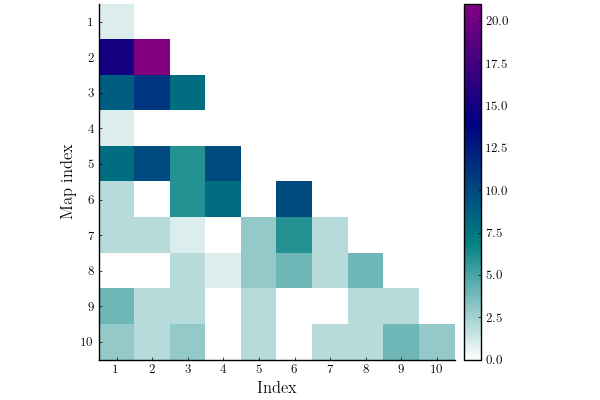

In [84]:
plot(S)

In [85]:
stor = Storage(S[10].I.f, X);

In [86]:
q = QRscaling(stor)

QRscaling([-70.71067811865474 -1.1980217074361534 … -0.4099029630388107 44.1258226248066; 0.0 70.70052859765981 … -30.897418799058958 -2.3212184785821184; … ; 0.0 0.0 … 58.43102445900099 0.15154359705397197; 0.0 0.0 … 0.0 26.649507892699322], [-0.014142135623730952 -0.0002396387382497817 … -0.0009438398247274573 -0.02036495613475948; 0.0 0.014144165819335896 … 0.007441837922947063 0.00046013662691832995; … ; 0.0 0.0 … 0.017114195913194456 -9.732062670029193e-5; 0.0 0.0 … 0.0 0.03752414506212896], [0.44540516159756 0.0 … 0.0 0.0; 0.0 0.3833529951572955 … 0.0 0.0; … ; 0.0 0.0 … 0.3911154240296415 0.0; 0.0 0.0 … 0.0 0.3287533858397667], [2.245146860025697 0.0 … 0.0 0.0; 0.0 2.6085618545635336 … 0.0 0.0; … ; 0.0 0.0 … 2.5567899872039126 0.0; 0.0 0.0 … 0.0 3.0417937672203825], [-31.494901014112465 -0.4592652098091066 … -0.16031937119993092 14.506513590870153; 0.0 27.10325939711691 … -12.084457055015362 -0.7631084341077035; … ; 0.0 0.0 … 22.853274907768526 0.04982047063383058; 0.0 0.0 … 0.0 

In [87]:
P = zeros(ncoeff(S[10]), ncoeff(S[10]))
precond!(P, getcoeff(S[10]), stor, S[10], X)

Pqr = zeros(ncoeff(S[10]), ncoeff(S[10]))
qrprecond!(Pqr, q.U*getcoeff(S[10]), q, stor, S[10], X)

21×21 Array{Float64,2}:
  0.000200002   3.41658e-11  -4.92123e-10  …  -2.29046e-6   -3.51571e-6
  3.41658e-11   0.000200003  -1.21959e-10      5.36706e-8   -7.92199e-8
 -4.92123e-10  -1.21959e-10   0.000200004      9.6502e-7     2.0544e-6
 -4.64474e-9   -5.79473e-11   4.32122e-9      -3.81286e-7   -5.48611e-8
  7.47192e-11  -3.61401e-11  -1.16495e-10     -3.62053e-8   -5.40012e-7
  4.12227e-9    6.0338e-11   -3.16008e-9   …   1.56485e-7    1.06235e-6
 -0.000100177   2.8636e-6     4.01674e-5       1.28899e-6    3.57581e-5
  1.28414e-5   -3.66983e-7   -5.15004e-6      -2.24782e-8   -3.71759e-6
 -7.84879e-7    2.24409e-8    3.14644e-7       4.23074e-8    1.96249e-7
 -1.26251e-5    3.60843e-7    5.06357e-6      -5.55669e-8    4.69336e-6
 -1.30851e-5    3.73946e-7    5.24755e-6   …   6.85259e-8    3.63899e-6
 -3.28538e-7    9.39704e-9    1.31668e-7      -5.96362e-8    2.74234e-7
  1.41688e-6   -4.04573e-8   -5.68211e-7      -3.79612e-8   -1.96144e-7
  1.28464e-6   -6.4366e-7     1.56905e-6 

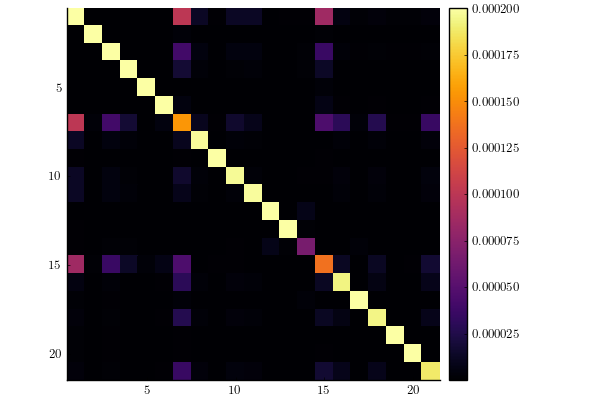

In [88]:
heatmap(abs.(Pqr), yflip = true, ratio = 1.0)

In [89]:
cond(P)

1169.0826102239932

In [90]:
cond(Pqr)

8.101221661048028

In [91]:
F = evaluate(S, X)

10×5000 Array{Float64,2}:
 -0.587737    0.772038   -0.513848   …   0.257944  -0.185298   -1.1379
  1.14249     0.780354   -0.0967821     -0.88244    1.35998    -0.374858
 -1.67727    -0.677774   -0.480753      -0.203625  -0.017663    0.498706
 -2.03744    -0.379185    0.806625       1.20382   -0.69578     0.196961
  0.644289    0.0685937  -0.331295       0.192915  -0.977204    0.47167
  0.209888   -0.856833   -0.467456   …   0.414549  -0.541834   -0.183365
 -0.188996   -0.479771    1.43579        0.369227  -1.26226    -1.73543
 -0.0540521   0.752656   -0.784957       1.30061   -0.0983102   0.0539654
  1.60606    -1.34042     0.27559        0.28694   -0.900953    0.775596
 -0.287808   -0.896095   -0.718431       1.00005   -1.19073    -1.6621

In [49]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

10×10 Array{Float64,2}:
     2.68172e7   9087.98       4451.6        …      0.0            0.0
  9087.98           2.3674e7  11304.8            3799.88         134.295
  4451.6        11304.8           2.29709e7     16201.2         2411.3
   192.226        115.304       214.486             0.0            0.0
  7124.89         838.711      2467.0             105.375       1976.41
     3.56917     2644.11       6304.7        …    216.721      26299.5
 14853.0         6357.72       8657.16             79.6053         0.0
  2171.48        1150.18        590.895             0.0          117.861
     0.0         3799.88      16201.2               2.12412e7      0.0
     0.0          134.295      2411.3               0.0            2.65976e7

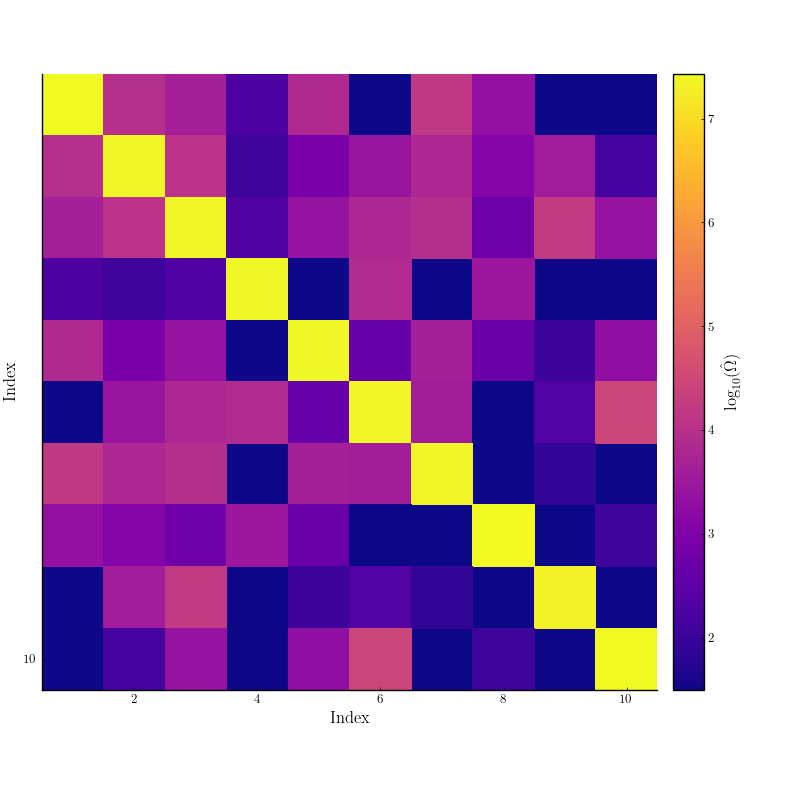

In [50]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

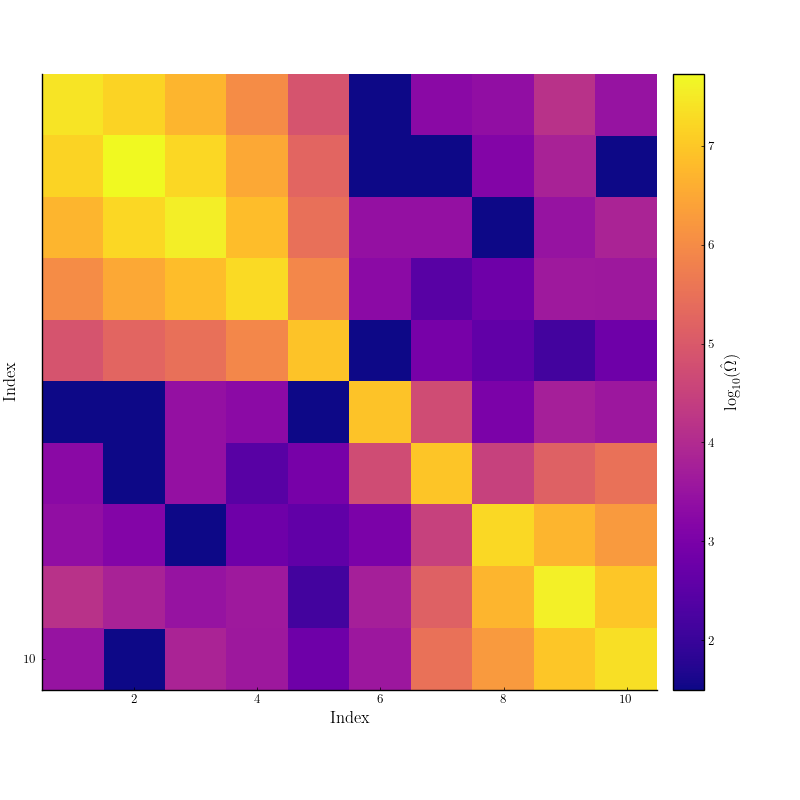

In [38]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(abs.(Ωhat - Σ.^2)), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt